Author: Darshan Sundaram

I start off my analysis by importing the dataset and checking for any missing values. I will then pre-process the data according to a few parameters I define. Namely, I will remove stopwords, punctuation, noise words and numbers. This would help remove the noise from the dataset and allow for a more robust input into our embedding layers in the NN. 

I will divide by dataset into training and testing (75/25 split). I will not manually divide my data into a validation set as there is an inbuilt option to split within the neural network. I start off inputting my cleaned text into the inbuilt keras Tokenizer which builds on a vocabulary on the data it is trained on and translates that into a sequence of integers for each words that escapes the filters I set such as vocabulary size, max document lenght and output length from the embdedding layer. These are all parameters that I experimented with to find an optimal pairing. I use these vectors for each document within my corpus and run it through glove embeddings, which will enable me to still retain meaning in vector space, and also considers global fequency information to build a coherent co-occurence matrix and eventually build a weight matrix for our word vectors output. I will then run it through a bidirectional LSTM allows us to preserve information from the future (words after our target word) to the past and past (words from the past before our target word) to the future and allows us to gain a better contextual understanding. I experimented with two hidden fully connected dense layers but my accuracy took a dip so I chose not to include them. However, I am certain a more complex model with deeper hidden layers could abstract more information. The output layer is a dense layer of size 1 (binary) with signmoid and a loss function of binary cross entropy (one of the few choices we have) and an adam optimizer. I experimented with SGD but results were poorer. Hence Adam as chosen as my main optimizer. The accompanying parameters such as batch_size and epochs were also tuned to abstract the highest accuracy. Within this next step, I can define my validation split to test on a held out set.  

In [32]:
import pandas as pd
# packages you may need to import
from sklearn.datasets import load_files
from scipy.stats import uniform, randint as sp_randint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import KFold,StratifiedKFold,RandomizedSearchCV, GridSearchCV
import nltk
from nltk.cluster import KMeansClusterer, cosine_distance
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
import string
from sklearn.pipeline import make_pipeline, Pipeline
from nltk import pos_tag
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing, svm
#from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA


In [34]:
q2 = pd.read_csv("yelp_labelled.txt", sep = '\t', header = None)
q2.columns = (["Review", "Rating"])
text_raw = q2["Review"]

In [36]:
#Removing stopwords and other characters as defined by me
from nltk.stem import WordNetLemmatizer
tuk_ready_stem = []
from nltk.stem.snowball import SnowballStemmer

stem = SnowballStemmer("english")

stopw = stopwords.words('english') + list(string.punctuation)  +["’","”","—","“"]


for i in range(0,len(text_raw)):
    x = text_raw[i]
    text = re.sub(r'((.)\2{2,})', ' ', x) #remove three or more consecutive characters like 'trashhhh'
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    
   
    #Words
    tokens = [stop for stop in word_tokenize(text.lower()) if stop not in stopw] #removes stopwords, punctuation and custom filter
    #tokens = [w for w in tokens if w.isalpha()]  #remove every that is not fully alphabetic
    tokens = [w for w in tokens if re.findall(r"(\w{2})",w) ] #removes anything less than 3 characters
    #tokens = [stem.stem(w) for w in tokens]
    review = ' '.join(tokens)
    tuk_ready_stem.append(review)
    


In [37]:

y = q2["Rating"]

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tuk_ready_stem, y, test_size=0.25, random_state=1)



In [39]:
from keras.models import Sequential 
from keras.layers import Dense, Embedding,Conv1D, GlobalMaxPooling1D, LSTM, MaxPooling1D, Bidirectional, Flatten, Dropout
from keras import layers, models, callbacks, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [40]:

max_words = 20000

tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
tok_train = tok.texts_to_sequences(X_train)
tok_test = tok.texts_to_sequences(X_test)

In [41]:
maxlen = 100
tok_train = pad_sequences(tok_train, padding = "post", maxlen = maxlen)
tok_test= pad_sequences(tok_test, padding = "post", maxlen = maxlen)
#scaler = StandardScaler()
#tok_train1 = scaler.fit_transform(tok_train)
#tok_test1 = scaler.transform(tok_test)

In [138]:
#code adapted from https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb
embeddings_index = dict()
f = open('glove.6B.300d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [139]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_words, 300))
for word, index in tok.word_index.items():
    if index > max_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [144]:
#-------------------------Random state-------------------------------------------------------------#

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(425)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(235)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(235)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#-------------------------Random state-------------------------------------------------------------#



model_glove = Sequential()
model_glove.add(Embedding(max_words, 300, input_length=100, weights=[embedding_matrix], trainable=False))
model_glove.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))

model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [145]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.01,patience=1, verbose=0, mode='auto')
History = model_glove.fit(tok_train, y_train, validation_split=0.3, epochs = 20,batch_size = 7, verbose = 2,callbacks=[early_stopping])



Train on 525 samples, validate on 225 samples
Epoch 1/20
 - 97s - loss: 0.6116 - acc: 0.6457 - val_loss: 0.5330 - val_acc: 0.7378
Epoch 2/20
 - 90s - loss: 0.4655 - acc: 0.8038 - val_loss: 0.3980 - val_acc: 0.8356
Epoch 3/20
 - 90s - loss: 0.4117 - acc: 0.8152 - val_loss: 0.3849 - val_acc: 0.8267
Epoch 4/20
 - 89s - loss: 0.3610 - acc: 0.8248 - val_loss: 0.3695 - val_acc: 0.8311
Epoch 5/20
 - 90s - loss: 0.3210 - acc: 0.8667 - val_loss: 0.3766 - val_acc: 0.8400


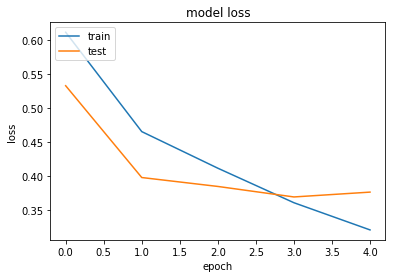

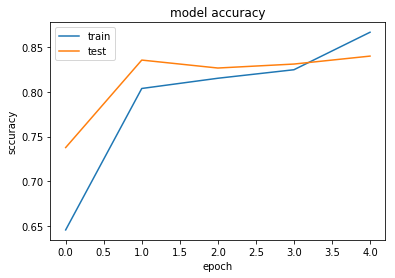

In [146]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('sccuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Looks like the best epoch is at 4 or index 3 on the graph. With early stopping I slightly overfit my model on the training data as seen on the graph. 

In [149]:
prednn = model_glove.predict(tok_test)
prednn1  = (prednn > 0.5).astype(np.int)
print("The accuracy is, ", accuracy_score(y_test,prednn1)*100, "%")

The accuracy is,  78.8 %


In [151]:
print(classification_report(y_test,prednn1))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       134
           1       0.79      0.74      0.76       116

   micro avg       0.79      0.79      0.79       250
   macro avg       0.79      0.78      0.79       250
weighted avg       0.79      0.79      0.79       250



As explained before, by using a bidirectional LSTM layer we abstract a higher level of contextual information. Running through the Tokenizer and the 300 wide Glove vector weights, we get a robust feature space. The parameters were tuned manually to improve model performance. I implement an early stopping condition on val loss and to prevent overfitting and come to find out the optimal value of epoch of lowest val_loss is at epoch 4 by looking at the loss graph. I overfit my model slightly by training it an extra epoch (this is my decision as I want to overfit a slight amount). This decision was proved to be the right decision as the training accuracy and testing accuracy was seen to increase with an extra epoch. Using this point as my final model, I predict on unseen testing data that was kept aside previously. The accuracy comes out to 78.8%, which is a respectable score. The F1 score dilenated by the labels, tell us that the model is more robust at detecting the negative label reviews as opposed to the positive label reviews. This is understandable as in my opinion negative reviews have stronger words that swing the sentiment more like (bad,terrible etc.), whereas "pretty good but not the best" could still be a negative review. Precision is fairly constant across the two classes and recall is a bit unbalanced with 83% for negative reviews and 74% for positive. This follows the same logic as before. 


Further steps could be implementing hidden fully connected dense layers, Con1d and max pooling layers before the LSTM. 